In [1]:
import cranet
from cranet import nn
from cranet import data

import numpy as np
import matplotlib.pyplot as plt

from typing import (
    Any,
    Iterable,
    Callable,
)


In [2]:
def create_curve(func: Callable[[Any], Any], data_range: Iterable[int], sample_num: int):
    x = np.linspace(*data_range, num=sample_num)
    return x, func(x)


def plot_curve(model, curve):
    pred_curve = np.array([model(x).numpy() for x, _ in curve]).squeeze()
    plt.scatter(curve.x, pred_curve)
    return pred_curve


In [3]:
class FNN(nn.Module):
    def __init__(self, features: Iterable[int]):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(features[0], features[1]),
            nn.Tanh(),
            nn.Linear(features[1], features[2]),
        )

    def forward(self, x):
        return self.layer(x)

    def fit(self, curvedata, epochs, lr=1e-2, opt_func=cranet.optim.SGD, loss_func=cranet.nn.loss.MSELoss):
        history = []
        optimizer = opt_func(self.parameters(), lr=lr)
        loss_func = loss_func()
        for epoch in range(epochs):
            # Training Phase
            self.train()
            train_losses = []
            for x, y in curvedata:
                pred = self(x)
                loss = loss_func(pred, y)
                train_losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            result = cranet.stack(train_losses).mean().numpy()
            if epoch % 10 == 0:
                print(f"{epoch}/{epochs} loss:{result}")
            history.append(result)

        return history


In [4]:
sin = lambda x : 1 + np.sin(np.pi/4 * x)
curve = create_curve(sin, [-2, 2], 30)

Text(0.5, 1.0, '')

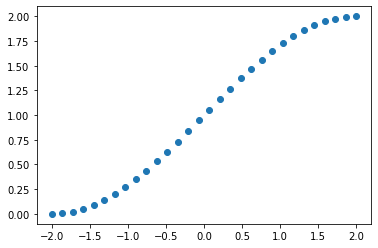

In [5]:
plt.scatter(*curve)
plt.title("")

In [6]:
class CurveDataset(data.Dataset):
    def __init__(self, curvedata, transform=None, target_transform=None):
        self.x, self.y = curvedata
        self.transform = transform
        self.target_transform = target_transform
        assert len(self.x) == len(
            self.y), "x_data and y_data of the curve data must have same length"

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_data = cranet.tensor(self.x[idx].reshape(1))
        y_data = cranet.tensor(self.y[idx].reshape(1))
        if self.transform:
            x_data = self.transform(x_data)
        if self.target_transform:
            y_data = self.target_transform(y_data)
        return x_data, y_data


In [7]:
train_ds = CurveDataset(curve)
train_dl = data.DataLoader(train_ds, shuffle=True)

In [8]:
fnn = FNN([1, 13, 1])

In [9]:
history = fnn.fit(train_dl, epochs=100)

0/100 loss:0.2833610490949907
10/100 loss:0.004296549747028176
20/100 loss:0.0025440688814532078
30/100 loss:0.0017744299902289395
40/100 loss:0.0013939700090967139
50/100 loss:0.0011805683859202108
60/100 loss:0.001045605826491198
70/100 loss:0.000951235525493451
80/100 loss:0.0008800651943687943
90/100 loss:0.0008234661197511603


Text(0, 0.5, 'loss')

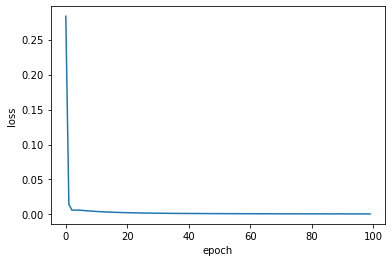

In [10]:
plt.plot(history)
plt.xlabel("epoch")
plt.ylabel("loss")

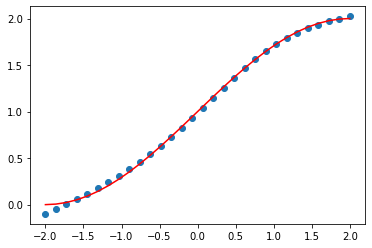

In [11]:
plot_curve(fnn, train_ds)
plt.plot(*curve, 'r')